In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm
import os
from PIL import Image

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
train_dir = r"F:\Project\GPU\CV\brain2_filtered\Training"
test_dir = r"F:\Project\GPU\CV\brain2_filtered\Testing"

print("Training directory exists:", os.path.exists(train_dir))
print("Testing directory exists:", os.path.exists(test_dir))

Using device: cuda
Training directory exists: True
Testing directory exists: True


In [3]:
# Transforms with light augmentation (helps accuracy, minimal speed cost)
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

# Large batch size + optimized loader
batch_size = 96  # Try 128 if you have 12GB+ VRAM; drop to 64 if OOM

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True, prefetch_factor=2, persistent_workers=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True, prefetch_factor=2, persistent_workers=True
)

class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training images: {len(train_dataset)} | Batches: {len(train_loader)}")
print(f"Testing images: {len(test_dataset)} | Batches: {len(test_loader)}")

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training images: 5712 | Batches: 60
Testing images: 1311 | Batches: 14


In [4]:
# Swin-T is much faster than ViT-B/16 and great for medical images
model = models.swin_t(weights="IMAGENET1K_V1")

# Modify head for 4 classes
num_classes = len(class_names)
model.head = nn.Linear(model.head.in_features, num_classes)

model = model.to(device)

print(f"Swin-T model ready for {num_classes} classes")

Swin-T model ready for 4 classes


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)  # AdamW often converges faster

scaler = torch.amp.GradScaler('cuda')

def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [6]:
# Lists to store metrics for plotting
train_losses = []
train_accs = []
test_losses = []
test_accs = []

num_epochs = 15

print("Starting fast training with Swin-T...\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}\n")

print("Training completed!")

Starting fast training with Swin-T...

Epoch 1/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.4797 | Train Acc: 0.8053


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.2008 | Test Acc:  0.9298

Epoch 2/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.2409 | Train Acc: 0.9090


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.2545 | Test Acc:  0.9268

Epoch 3/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.2053 | Train Acc: 0.9266


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.1362 | Test Acc:  0.9535

Epoch 4/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1950 | Train Acc: 0.9328


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0701 | Test Acc:  0.9764

Epoch 5/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1703 | Train Acc: 0.9380


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0690 | Test Acc:  0.9771

Epoch 6/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1331 | Train Acc: 0.9520


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0711 | Test Acc:  0.9779

Epoch 7/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1490 | Train Acc: 0.9436


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.1137 | Test Acc:  0.9649

Epoch 8/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1266 | Train Acc: 0.9547


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0469 | Test Acc:  0.9870

Epoch 9/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1276 | Train Acc: 0.9533


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0409 | Test Acc:  0.9878

Epoch 10/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1262 | Train Acc: 0.9529


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0437 | Test Acc:  0.9878

Epoch 11/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1228 | Train Acc: 0.9583


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0374 | Test Acc:  0.9870

Epoch 12/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1223 | Train Acc: 0.9573


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0268 | Test Acc:  0.9916

Epoch 13/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1079 | Train Acc: 0.9569


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0575 | Test Acc:  0.9870

Epoch 14/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.1077 | Train Acc: 0.9617


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0263 | Test Acc:  0.9931

Epoch 15/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Train Loss: 0.0972 | Train Acc: 0.9662


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Test Loss:  0.0365 | Test Acc:  0.9916

Training completed!


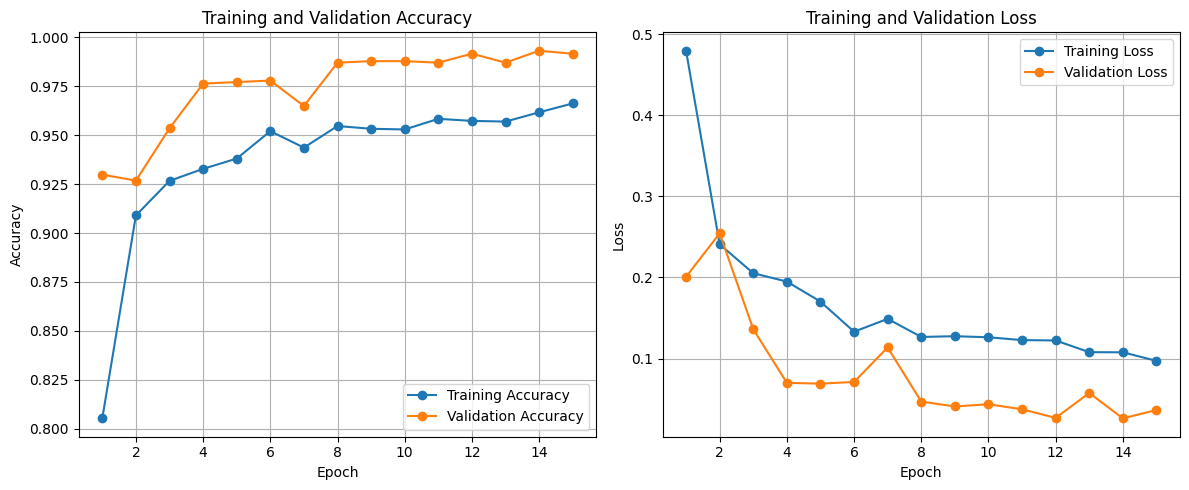

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), test_accs, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Create a dictionary with everything useful
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accs': train_accs,
    'test_losses': test_losses,
    'test_accs': test_accs,
    'num_epochs_completed': num_epochs,
    'class_names': class_names,
    'final_test_accuracy': test_accs[-1] if test_accs else None
}

# Save path
model_save_path = "swin_t_brain_tumor_best.pth"

torch.save(checkpoint, model_save_path)
print(f"Full model checkpoint saved to: {model_save_path}")
print(f"Final Test Accuracy: {test_accs[-1]:.4f}" if test_accs else "No test accuracy recorded")

Full model checkpoint saved to: swin_t_brain_tumor_best.pth
Final Test Accuracy: 0.9916


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get all predictions and true labels on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Computing predictions"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)

# Normalized confusion matrix (percentages)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("\nNormalized Confusion Matrix:")
print(np.round(cm_norm, 3))

Computing predictions:   0%|          | 0/14 [00:00<?, ?it/s]

Confusion Matrix:
[[298   2   0   0]
 [  1 300   5   0]
 [  0   0 405   0]
 [  1   2   0 297]]

Normalized Confusion Matrix:
[[0.993 0.007 0.    0.   ]
 [0.003 0.98  0.016 0.   ]
 [0.    0.    1.    0.   ]
 [0.003 0.007 0.    0.99 ]]


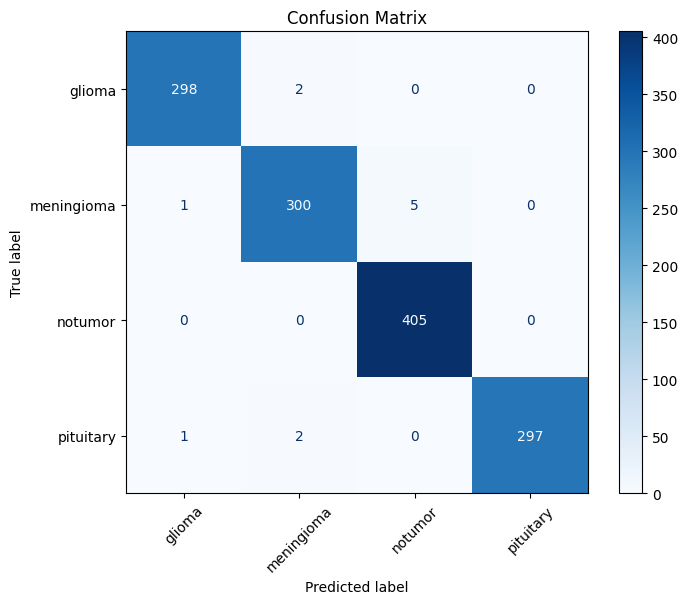

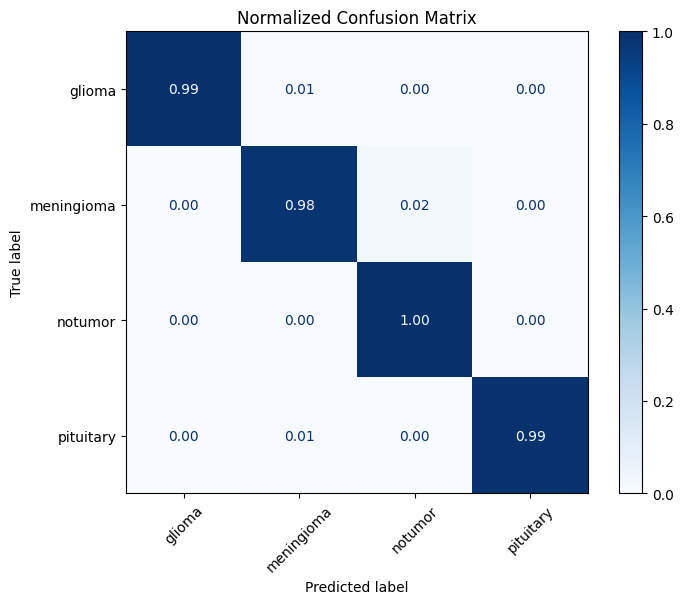

In [10]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

# Optional: Normalized version
fig, ax = plt.subplots(figsize=(8, 6))
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp_norm.plot(ax=ax, cmap='Blues', values_format='.2f')
ax.set_title('Normalized Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

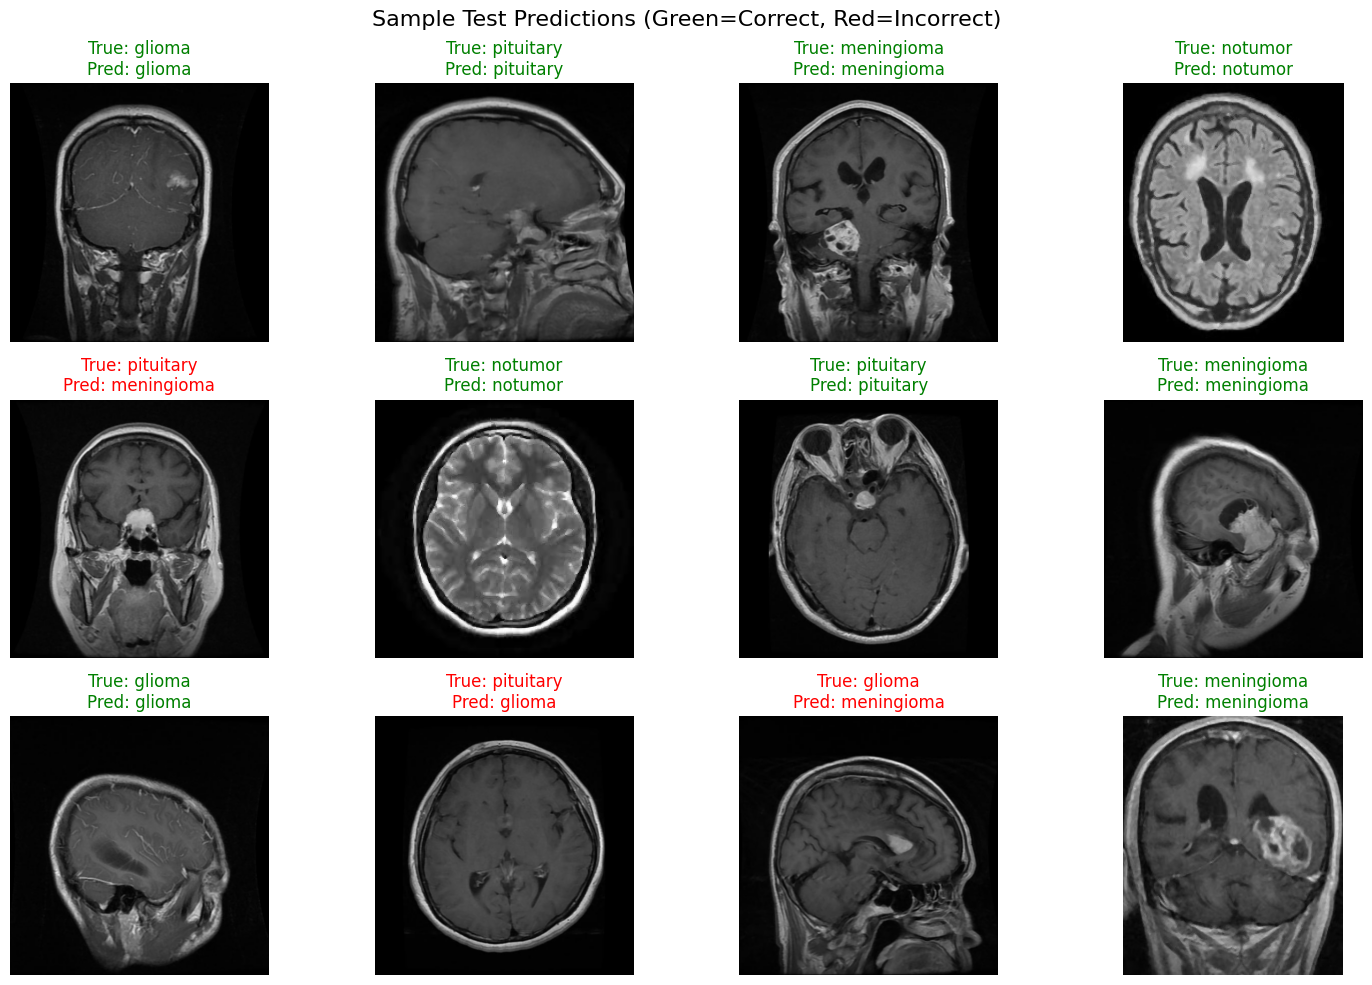

Total test accuracy: 0.9916
Number of misclassifications shown: 3


In [11]:
import random

# Find correct and incorrect predictions
correct_indices = np.where(all_preds == all_labels)[0]
incorrect_indices = np.where(all_preds != all_labels)[0]

# Select up to 9 correct and 3 incorrect (total 12)
num_correct = min(9, len(correct_indices))
num_incorrect = min(3, len(incorrect_indices))

selected_indices = (
    random.sample(list(correct_indices), num_correct) +
    random.sample(list(incorrect_indices), num_incorrect)
)
random.shuffle(selected_indices)  # Mix them

# Plot
fig = plt.figure(figsize=(15, 10))
for i, idx in enumerate(selected_indices):
    # Get image path from dataset
    img_path = test_dataset.imgs[idx][0]
    true_label = class_names[all_labels[idx]]
    pred_label = class_names[all_preds[idx]]
    
    img = Image.open(img_path).convert("RGB")
    
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(img)
    ax.axis('off')
    
    title_color = 'green' if all_preds[idx] == all_labels[idx] else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color, fontsize=12)

plt.suptitle("Sample Test Predictions (Green=Correct, Red=Incorrect)", fontsize=16)
plt.tight_layout()
plt.show()

# Print summary
print(f"Total test accuracy: {np.mean(all_preds == all_labels):.4f}")
print(f"Number of misclassifications shown: {num_incorrect}")